In [1]:
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
data = pd.read_csv('../Data/housing.csv')

### Extracting required data from the dataset

In [2]:
data = pd.get_dummies(data, columns=["ocean_proximity"])
data["bedrooms_by_totalrooms"] = data["total_bedrooms"]/data["total_rooms"]
data = data[data["median_house_value"] < 500001] # to remove all capped data
data = data.dropna(subset=["total_bedrooms"])  #dropping all NA values

# Refer EDA notebook for the reasoning behind choosing these features

X = data[["median_income", "ocean_proximity_<1H OCEAN", "ocean_proximity_INLAND", "bedrooms_by_totalrooms"]]
y = data["median_house_value"]
X = X.fillna(X.mean())
y = y.fillna(y.mean())

### Preprocessing

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
means = X_train.mean()
stds = X_train.std()

X_train_scaled = (X_train - means) / stds
X_test_scaled = (X_test - means) / stds
X_train_scaled.head()

,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,bedrooms_by_totalrooms
5148,-1.606564,1.137598,-0.704397,0.958457
1378,-0.013762,-0.878989,-0.704397,-0.416681
10567,0.282519,1.137598,-0.704397,-0.134610
16253,-0.709042,-0.878989,1.419563,-0.341646
3920,0.319714,1.137598,-0.704397,-0.272353


### Timer decorator

In [4]:
import time
def timer(func):
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        duration = end - start
        if args and hasattr(args[0], '__dict__'):
            setattr(args[0], f'{func.__name__}_time', duration)
        print(f"Function '{func.__name__}' took {duration:.4f} seconds")
        return result
    return wrapper

### Linear Regression Model

In [5]:
class linear_regression:
    def __init__(self, lr=0.01, iters=1000):
        self.lr = lr
        self.iters = iters
        self.weights = None 
        self.converged_iter_mse = None
        self.converged_time_mse = None
        self.converged_iter_mae = None
        self.converged_time_mae = None
        self.converged_iter_rmse = None
        self.converged_time_rmse = None
        self.converged_iter_r2 = None
        self.converged_time_r2 = None
        self.bias = 0.0     
        self.history = {'mse': [], 'rmse': [], 'mae': [], 'r2': []}

    @timer #timer decorator
    def fit(self, X: pd.DataFrame, y: pd.Series):
        records = [row.tolist() for _, row in X.iterrows()] #convert to list of lists
        targets = y.tolist()

        n_samples = len(records)
        n_features = len(records[0]) #each record has number of features

        self.weights = [0.0] * n_features

        # will be used in convergence checking
        prev_mse = float('inf')
        prev_rmse = float('inf')
        prev_mae = float('inf')
        prev_r2 = float('inf')

        t_start = time.perf_counter() #for measuring the convergence time

        for iter in range(self.iters):
            
            # gradient descent (batch gradient descent)
            grad_w = [0.0] * n_features
            grad_b = 0.0

            for xi, yi in zip(records, targets):
                y_pred = sum(w * x for w, x in zip(self.weights, xi)) + self.bias
                error = y_pred - yi
                for j in range(n_features):
                    grad_w[j] += (2 / n_samples) * error * xi[j]
                
                grad_b += (2 / n_samples) * error # single bias, so no loop

            for j in range(n_features):
                self.weights[j] -= self.lr * grad_w[j] #changing weights

            self.bias -= self.lr * grad_b

            # Record metrics
            preds = [sum(w * x for w, x in zip(self.weights, xi)) + self.bias for xi in records]
            errors_sq = [(p - t) ** 2 for p, t in zip(preds, targets)]
            errors_abs = [abs(p - t) for p, t in zip(preds, targets)]
            mean_y = sum(targets) / n_samples
            ss_tot = sum((t - mean_y) ** 2 for t in targets)
            ss_res = sum((t - p) ** 2 for t, p in zip(targets, preds))
            mse = (sum(errors_sq) / n_samples)
            mae  = sum(errors_abs)/n_samples
            rmse = math.sqrt(mse)
            r2 = 1 - (ss_res/ss_tot)

            # save error metrics for plotting
            self.history['mse'].append(mse)
            self.history['rmse'].append(math.sqrt(mse))
            self.history['mae'].append(sum(errors_abs) / n_samples)
            self.history['r2'].append(1 - (ss_res / ss_tot))

            #checking if values have converged close enough (tolerance = 1e-3)
            if self.converged_iter_mse is None and (abs(prev_mse - mse) < 1e-3):
                self.converged_iter_mse = iter
                self.converged_time_mse = time.perf_counter() - t_start
            if self.converged_iter_mae is None and (abs(prev_mae - mae) < 1e-3):
                self.converged_iter_mae = iter
                self.converged_time_mae = time.perf_counter() - t_start
            if self.converged_iter_rmse is None and (abs(prev_rmse - rmse) < 1e-3):
                self.converged_iter_rmse = iter
                self.converged_time_rmse = time.perf_counter() - t_start
            if self.converged_iter_r2 is None and (abs(prev_r2 - r2) < 1e-3):
                self.converged_iter_r2 = iter
                self.converged_time_r2 = time.perf_counter() - t_start

            # reassigning previous error metrics
            prev_mse = mse
            prev_mae = mae
            prev_rmse = rmse
            prev_r2 = r2

    def predict(self, X):
        records = [row.tolist() for _, row in X.iterrows()]
        preds = []
        for xi in records:
            preds.append(sum(w * x for w, x in zip(self.weights, xi)) + self.bias)
        return preds

    def mse(self, X, y):
        preds = self.predict(X)
        errors = [(yp - yt) ** 2 for yp, yt in zip(preds, y.tolist())]
        return sum(errors) / len(errors)
    
    def rmse(self, X, y):
        return math.sqrt(self.mse(X, y))

    def mae(self, X, y):
        preds = self.predict(X)
        abs_errors = [abs(yp - yt) for yp, yt in zip(preds, y.tolist())]
        return sum(abs_errors) / len(abs_errors)

    def r2(self, X, y):
        targets = y.tolist()
        preds = self.predict(X)
        mean_y = sum(targets) / len(targets)
        ss_tot = sum((yi - mean_y) ** 2 for yi in targets)
        ss_res = sum((yi - ypi) ** 2 for yi, ypi in zip(targets, preds))
        return 1 - (ss_res / ss_tot)



In [6]:
model = linear_regression(iters=2000)
model.fit(X_train_scaled,y_train)

Function 'fit' took 76.7436 seconds


In [7]:
print("MSE")
print(f"converged iter : {model.converged_iter_mse}")
print(f"converged time : {model.converged_time_mse}")
print("MAE")
print(f"converged iter : {model.converged_iter_mae}")
print(f"converged time : {model.converged_time_mae}")
print("RMSE")
print(f"converged iter : {model.converged_iter_rmse}")
print(f"converged time : {model.converged_time_rmse}")
print("R2")
print(f"converged iter : {model.converged_iter_r2}")
print(f"converged time : {model.converged_time_r2}")

MSE
converged iter : 1993
converged time : 76.2338077920001
MAE
converged iter : 1429
converged time : 54.890116215000035
RMSE
converged iter : 936
converged time : 36.090163258000075
R2
converged iter : 134
converged time : 5.0900178470001265


### Errors

In [8]:
model.mse(X_test_scaled,y_test)


4075249764.2236986

In [9]:
model.rmse(X_test_scaled,y_test)


63837.68294842552

In [10]:
model.mae(X_test_scaled,y_test)


46669.77144677977

In [11]:
model.r2(X_test_scaled,y_test)

0.5792234047613776

### Plots

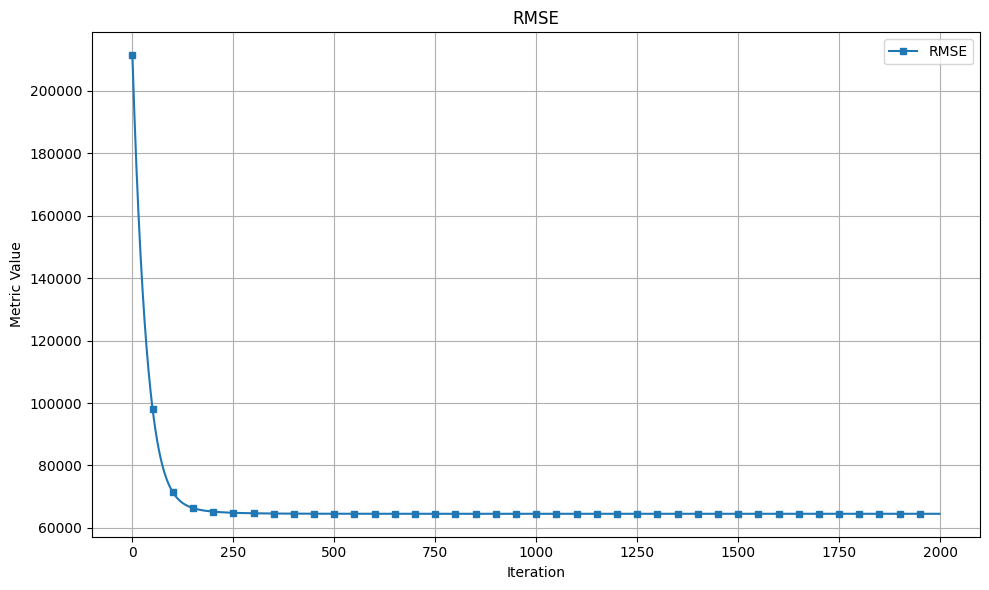

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(model.history['rmse'], label='RMSE', marker='s', markersize=4, markevery=50)
plt.xlabel('Iteration')
plt.ylabel('Metric Value')
plt.title('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

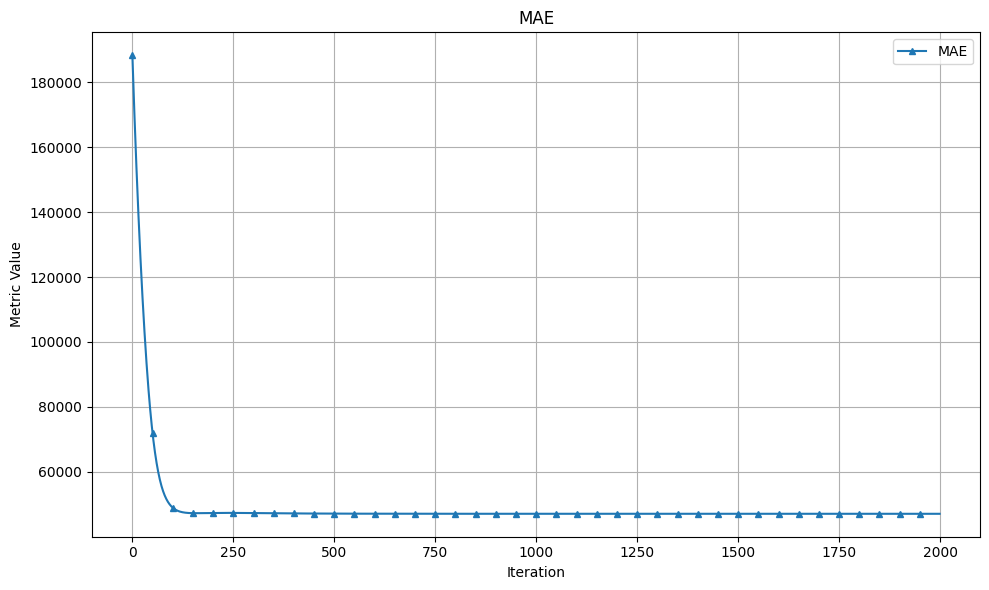

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(model.history['mae'], label='MAE', marker='^', markersize=4, markevery=50)
plt.xlabel('Iteration')
plt.ylabel('Metric Value')
plt.title('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

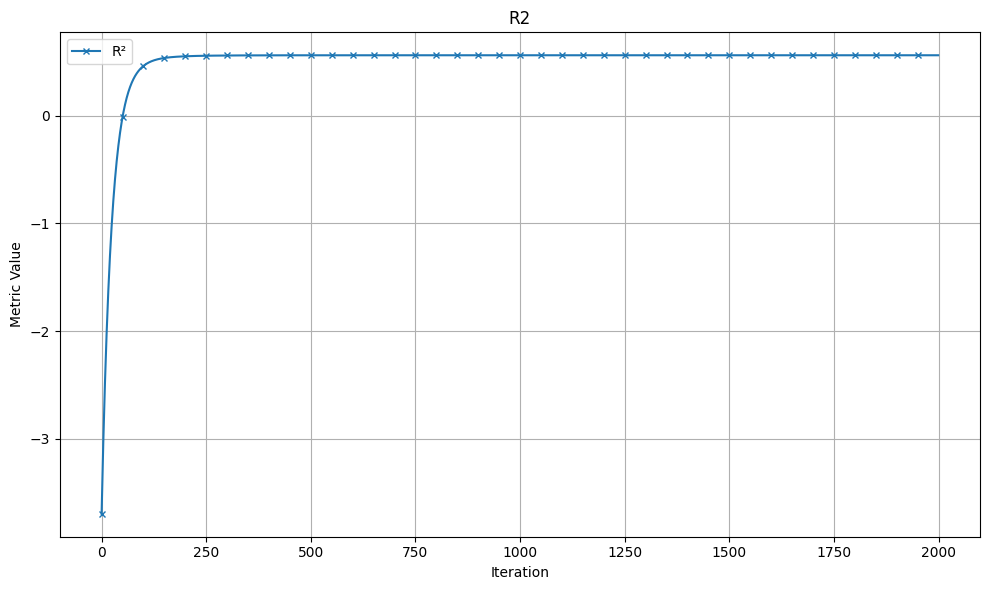

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(model.history['r2'], label='R²', marker='x', markersize=4, markevery=50)
plt.xlabel('Iteration')
plt.ylabel('Metric Value')
plt.title('R2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

 Since our outuput y is supposed to be very big the errors convergance is ususally late for metrics like MAE or MSE. Please note that we are considering the same tolearance for all the metrics that is $0.001$. $R^2$ is the quickest to converge in just $130$ iterations followed by RMSE in $919$ iterations and then MAE in $1446$ iterations.